In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [2]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

pd.set_option("display.precision", 3)

# Left join pour ajouter la table des features et des stores
X = pd.merge(pd.merge(train, features, on=['Store', 'Date'], how='left'),stores,on=['Store'], how='left')

# Ajout de la date en tant qu'index
X = X.set_index('Date').drop('IsHoliday_y',axis=1)

In [3]:
# Transformation des features categoriels
categorical_cols = ['IsHoliday_x','Type']
X = pd.get_dummies(X,columns=categorical_cols,drop_first=True)

# Imputing des valeurs manquantes
new_X = IterativeImputer(random_state=0).fit_transform(X)

# Transformation des arrays en DataFrames
new_X = pd.DataFrame(new_X,columns=X.columns)
new_X = new_X.set_index(X.index)

# Standardisation des features numeriques
numerical_features = ['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size','Weekly_Sales']
new_X[numerical_features] = StandardScaler().fit_transform(new_X[numerical_features])

# Reducion de la memoire utilisee
new_X = new_X.astype('float32')

In [4]:
# Creation d'un ensemble de donnees raffine par suppression des valeurs manquantes
alt_X = X.copy().dropna()
alt_X[numerical_features] = StandardScaler().fit_transform(alt_X[numerical_features]).astype('float32')

In [5]:
print("Taille de l'ensemble de données originel :",len(new_X.index),"entrees")
print("Taille de l'ensemble de données raffiné :",len(alt_X.index),"entrees")

Taille de l'ensemble de données originel : 421570 entrees
Taille de l'ensemble de données raffiné : 97056 entrees


Strategie : Etudier les relations entre les features

Etape 1 : creation d'un dataset sans na pour verifier le choix de l'imputing
Etape 2 : Etudier les distributions par magasin (enlever les variables size et type)

Top 10 Important Features:
        Feature  Importance
0          Dept       0.913
1     MarkDown3       0.020
2     MarkDown1       0.014
3     MarkDown4       0.011
4   Temperature       0.009
5    Fuel_Price       0.008
6     MarkDown5       0.008
7           CPI       0.008
8     MarkDown2       0.007
9  Unemployment       0.002


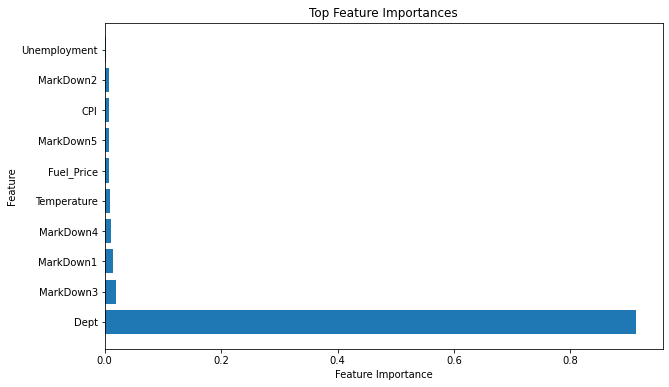

In [6]:
# Calcul de l'importance des features sur le dataset raffine (sans NaN values)
df_importance = pd.DataFrame(columns=['Feature', 'Importance'])

for i in range(1,len(alt_X['Store'].unique())+1):
    # Creation d'un dataset par magasin dont on enleve les features propres au magasin (Type, Size)
    test1 = alt_X[alt_X['Store']==i].drop('Size',axis=1).drop('Store',axis=1).drop('Type_B',axis=1).drop('Type_C',axis=1)

    # Utilisation d'un modele RF pour estimer l'importances des features
    model = RandomForestRegressor(n_estimators=50, random_state=0,verbose=0,n_jobs=-1)
    model.fit(test1.drop('Weekly_Sales',axis=1), test1['Weekly_Sales'])

    feature_importances = model.feature_importances_
    fts = pd.DataFrame({'Feature': test1.drop('Weekly_Sales',axis=1).columns, 'Importance': feature_importances})

    if len(df_importance.index)==0:
        df_importance = fts
    else:
        df_importance = pd.concat([df_importance,fts],axis=0)

# Calcul de l'importance moyenne des features en groupant l'ensemble des magasins
feature_importance_df = df_importance.groupby('Feature').mean().sort_values('Importance', ascending=False).reset_index()

# Afficher les 10 meilleurs features
top_n = 10  
print(f'Top {top_n} Important Features:')
print(feature_importance_df.head(top_n))

# Visualisation des 10 meilleurs features
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), feature_importance_df['Importance'][:top_n], align='center')
plt.yticks(range(top_n), feature_importance_df['Feature'][:top_n])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importances')
plt.show()

Top 10 Important Features:
        Feature  Importance
0          Dept       0.785
1     MarkDown3       0.075
2     MarkDown1       0.057
3     MarkDown2       0.021
4     MarkDown5       0.016
5   Temperature       0.013
6           CPI       0.010
7     MarkDown4       0.009
8    Fuel_Price       0.008
9  Unemployment       0.004


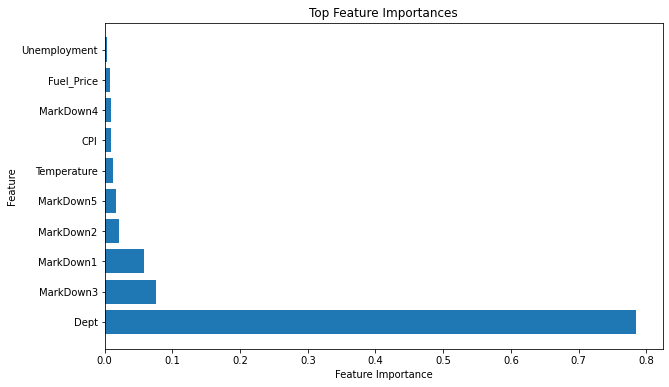

In [7]:
# Calcul de l'importance des features sur le dataset originel (valeurs imputees)
df_importance = pd.DataFrame(columns=['Feature', 'Importance'])

for i in range(1,len(new_X['Store'].unique())+1):
    # Creation d'un dataset par magasin
    test1 = new_X[new_X['Store']==i].drop('Size',axis=1).drop('Store',axis=1).drop('Type_B',axis=1).drop('Type_C',axis=1)

    # Utilisation d'un modele RF pour estimer l'importances des features
    model = RandomForestRegressor(n_estimators=50, random_state=0,verbose=0,n_jobs=-1)
    model.fit(test1.drop('Weekly_Sales',axis=1), test1['Weekly_Sales'])

    feature_importances = model.feature_importances_
    fts = pd.DataFrame({'Feature': test1.drop('Weekly_Sales',axis=1).columns, 'Importance': feature_importances})

    if len(df_importance.index)==0:
        df_importance = fts
    else:
        df_importance = pd.concat([df_importance,fts],axis=0)

# Calcul de l'importance moyenne des features en groupant l'ensemble des magasins
feature_importance_df = df_importance.groupby('Feature').mean().sort_values('Importance', ascending=False).reset_index()

# Afficher les 10 meilleurs features
top_n = 10  
print(f'Top {top_n} Important Features:')
print(feature_importance_df.head(top_n))

# Visualisation des 10 meilleurs features
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), feature_importance_df['Importance'][:top_n], align='center')
plt.yticks(range(top_n), feature_importance_df['Feature'][:top_n])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importances')
plt.show()

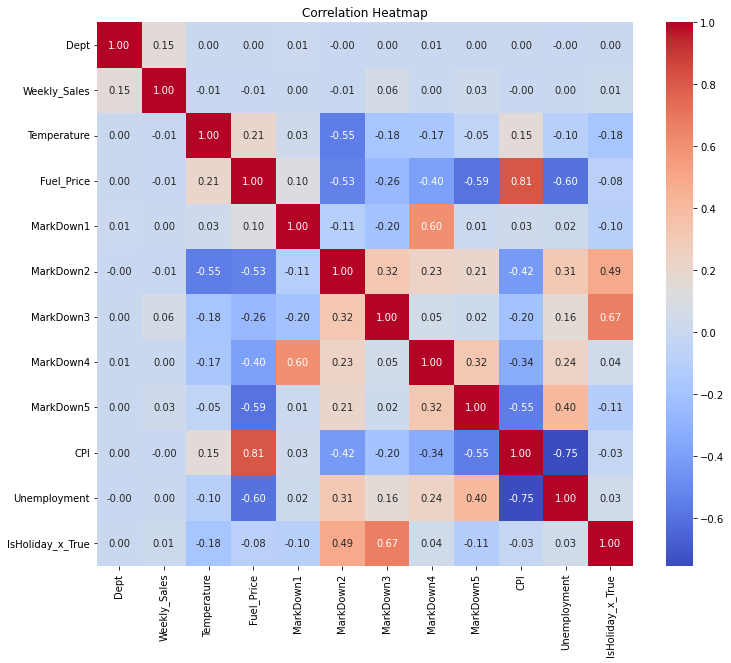

In [8]:
import seaborn as sns

for i in range(1,len(new_X['Store'].unique())+1):
    # Creation d'un dataset par magasin
    test1 = new_X[new_X['Store']==i].drop('Size',axis=1).drop('Store',axis=1).drop('Type_B',axis=1).drop('Type_C',axis=1)
    correlation_matrix = test1.corr()
    
    if i == 1:
        correlation_matrix_mean = correlation_matrix
    else:
        correlation_matrix_mean = correlation_matrix_mean + correlation_matrix


# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_mean/45, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Strategie 2
Etudier les distributions entre les variables sur l'ensemble des ventes

<AxesSubplot:xlabel='Date'>

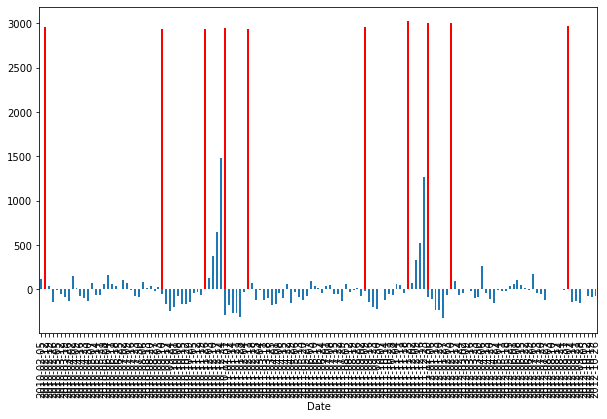

In [14]:
new_X['Weekly_Sales'].groupby('Date').sum().plot(kind='bar',figsize=(10, 6))
new_X['IsHoliday_x_True'].groupby('Date').sum().plot(kind='bar',figsize=(10, 6), color='red')

<AxesSubplot:xlabel='Date'>

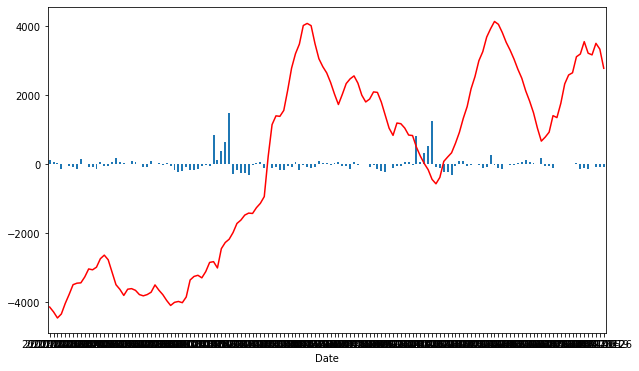

In [20]:
new_X['Weekly_Sales'].groupby('Date').sum().plot(kind='bar',figsize=(10, 6))
new_X['Fuel_Price'].groupby('Date').sum().plot(kind='line',figsize=(10, 6), color='red')

<AxesSubplot:xlabel='Date'>

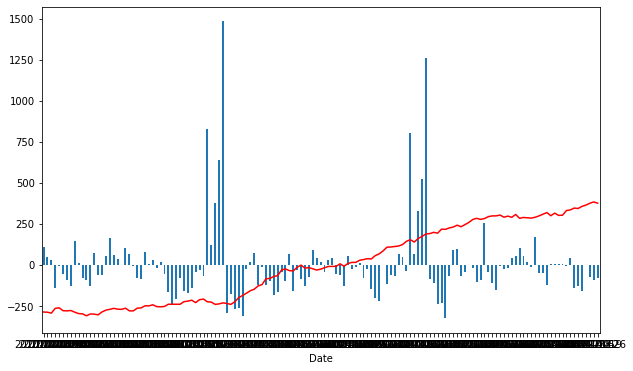

In [24]:
new_X['Weekly_Sales'].groupby('Date').sum().plot(kind='bar',figsize=(10, 6))
new_X['CPI'].groupby('Date').sum().plot(kind='line',figsize=(10, 6), color='red')

<AxesSubplot:xlabel='Date'>

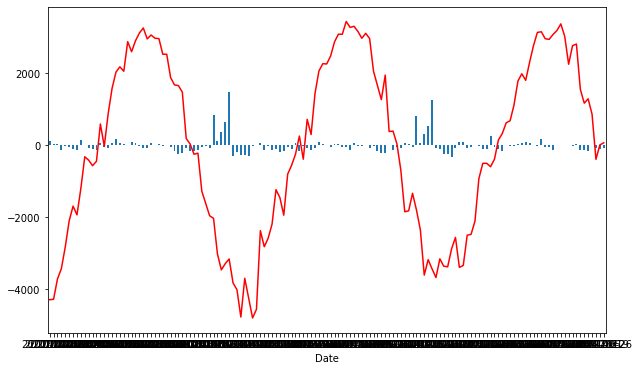

In [27]:
new_X['Weekly_Sales'].groupby('Date').sum().plot(kind='bar',figsize=(10, 6))
new_X['Temperature'].groupby('Date').sum().plot(kind='line',figsize=(10, 6), color='red')

<AxesSubplot:xlabel='Date'>

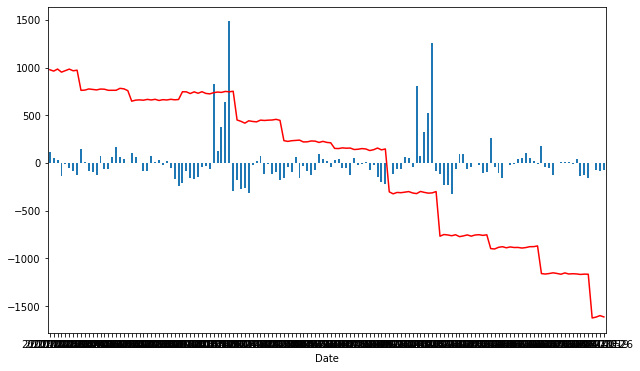

In [29]:
new_X['Weekly_Sales'].groupby('Date').sum().plot(kind='bar',figsize=(10, 6))
new_X['Unemployment'].groupby('Date').sum().plot(kind='line',figsize=(10, 6), color='red')

<AxesSubplot:xlabel='Date'>

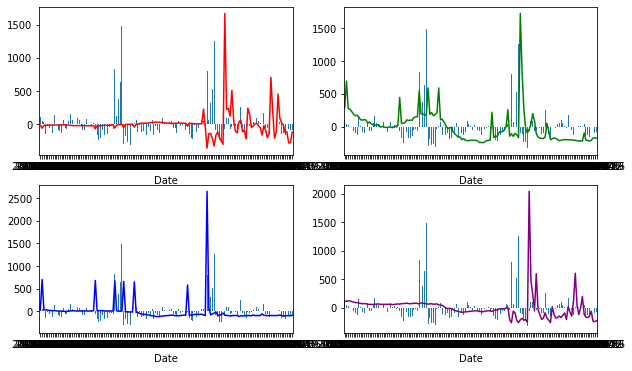

In [35]:
#I want to make a subplot where I want to see evolution of MarkDowns over time and compare it to the weekly sales using plt.subplot
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
new_X['Weekly_Sales'].groupby('Date').sum().plot(kind='bar',figsize=(10, 6))
(new_X['MarkDown1'].groupby('Date').sum()/10).plot(kind='line',figsize=(10, 6), color='red')
plt.subplot(2, 2, 2)
new_X['Weekly_Sales'].groupby('Date').sum().plot(kind='bar',figsize=(10, 6))
(new_X['MarkDown2'].groupby('Date').sum()/10).plot(kind='line',figsize=(10, 6), color='green')
plt.subplot(2, 2, 3)
new_X['Weekly_Sales'].groupby('Date').sum().plot(kind='bar',figsize=(10, 6))
(new_X['MarkDown3'].groupby('Date').sum()/10).plot(kind='line',figsize=(10, 6), color='blue')
plt.subplot(2, 2, 4)
new_X['Weekly_Sales'].groupby('Date').sum().plot(kind='bar',figsize=(10, 6))
(new_X['MarkDown4'].groupby('Date').sum()/10).plot(kind='line',figsize=(10, 6), color='purple')




Strategie 3
Etude des variables size et type sur les ventes

<AxesSubplot:xlabel='Store'>

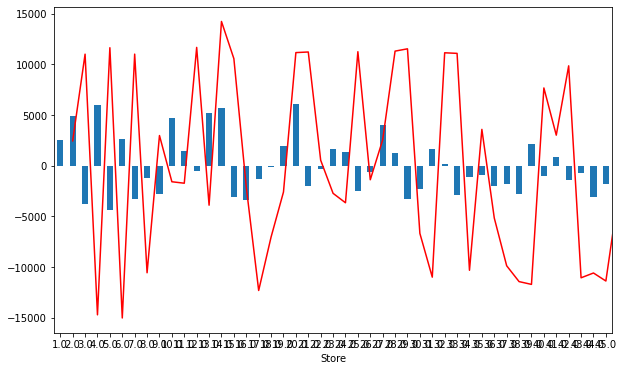

In [49]:
new_X.groupby('Store').sum()['Weekly_Sales'].plot(kind='bar',figsize=(10, 6))
new_X.groupby('Store').sum()['Size'].plot(kind='line',figsize=(10, 6), color='red')

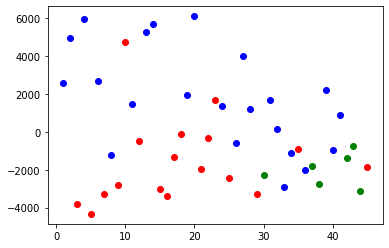

In [65]:
plt.scatter(new_X[(new_X['Type_B']==0) & (new_X['Type_C']==0)].groupby('Store').sum().index,new_X[(new_X['Type_B']==0) & (new_X['Type_C']==0)].groupby('Store').sum()['Weekly_Sales'],color='blue')
plt.scatter(new_X[(new_X['Type_B']==1) & (new_X['Type_C']==0)].groupby('Store').sum().index,new_X[(new_X['Type_B']==1) & (new_X['Type_C']==0)].groupby('Store').sum()['Weekly_Sales'],color='red')
plt.scatter(new_X[(new_X['Type_B']==0) & (new_X['Type_C']==1)].groupby('Store').sum().index,new_X[(new_X['Type_B']==0) & (new_X['Type_C']==1)].groupby('Store').sum()['Weekly_Sales'],color='green')